In [1]:
from casadi import *
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as la
from tqdm import tqdm

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


In [2]:
T = 15. # Time horizon
N = 100 # number of control intervals
x = MX.sym('x', 3)
u = MX.sym('u', 1)
lbd = MX.sym('lbd', 3)
N_pop = 5.3e6
u_min = 0.5
u_max = 6.5
Wu_max = N_pop**2/(u_max-u_min)*1e15
Wu_k = 2
Wu_list = [Wu_k]
while Wu_k < Wu_max:
    Wu_k = Wu_k**2
    Wu_list.append(Wu_k)
alpha = 0.2
beta = u*alpha
I0 = 2000
x0 = [N_pop - I0, I0, 0]

In [3]:
xdot = vertcat(-u*x[0]*x[1]/N_pop, u*x[0]*x[1]/N_pop - alpha*x[1], alpha*x[1])
lbd_dot = vertcat(0 - lbd[0]*u*x[1]/N_pop - lbd[1]*u*x[0]/N_pop, 2*x[1] + lbd[0]*u*x[1]/N_pop + lbd[1]*u*x[0]/N_pop, lbd[2]*alpha)
w = vertcat(x, lbd)
wdot = vertcat(xdot, lbd_dot)
F = Function('F', [w, u], [wdot])
Fx = Function('Fx', [x, u], [xdot])

In [4]:
def RK4_Integrator(f, X, U, DT):
       k1 = f(X, U)
       k2 = f(X + DT/2 * k1, U)
       k3 = f(X + DT/2 * k2, U)
       k4 = f(X + DT * k3, U)
       X=X+DT/6*(k1 +2*k2 +2*k3 +k4)
       return X

In [5]:

x0 = [N_pop-I0, I0, 0]
M = 50
t = np.linspace(0,T,N)
dt = np.diff(t)[0]/M
wk = w
x_plot = [x0]
for i in range(M):
    wk = RK4_Integrator(F, wk, u, dt)
    x_plot.append(wk[:3])

x_end = wk[:3]
lbd_end = wk[3:]
f_lbd = Function('f_lbd', [x, lbd, u], [lbd_end])
f = Function('f', [w, u], [wk])

lbd_k = lbd
xk = x0
U = MX.sym('U', len(t))
Wu = Wu_max

In [6]:
def argmin_H_u(x, lbd):
    return 1/(2*Wu)*(lbd[1]-lbd[0])*x[0]*x[1]/N_pop
def Hamiltonian(x, lbd, u):
    return x[1]**2 - Wu*u**2 + (lbd[1]-lbd[0])*x[0]*x[1]*u/N_pop + (lbd[2]-lbd[1])*alpha*x[1]

In [7]:
xk = x0
lbd_k = [0.5,0.2,0.3]
u_sols = []
Wu_list = np.logspace(0,np.log2(Wu_max),15, base=2)
#Wu_list = np.linspace(0,Wu_max,15)

x_sols = []
lbd_sols = []
for Wu in tqdm(Wu_list):
    def Hamiltonian(x, lbd, u):
        return x[1]**2 - Wu*u**2 + (lbd[1]-lbd[0])*x[0]*x[1]*u/N_pop + (lbd[2]-lbd[1])*alpha*x[1]
    u_list = []
    x_list = []
    lbd_list = []
    wk = vertcat(DM(xk), DM(lbd_k))
    xk = x0
    lbd_k = [0.1,0.2,0.3]
    for i in range(len(t)):
        S = wk[0]
        I = wk[1]
        lbd = wk[3:]
        #uk = 1/(2*Wu)*(lbd_k[1]-lbd_k[0])*S*I/N_pop
        H1 = Hamiltonian(xk, lbd_k, u_min)
        H2 = Hamiltonian(xk, lbd_k, u_max)
        print(H1, H2)
        if H1 < H2:
            uk = u_min
        else:
            uk = u_max
            
        lbd_k = f_lbd(xk, lbd_k, uk)
        wk = f(wk, uk)
        u_list.append(uk)
        x_list.append(wk[:3].full())
        lbd_list.append(wk[3:].full())
    u_sols.append(u_list)
    x_sols.append(x_list)
    lbd_sols.append(lbd_list)

  7%|█████▌                                                                             | 1/15 [00:00<00:01,  8.33it/s]

4000139.712264151 4001297.2594339624
4.41017e+006 1.24226e+007
4.90122e+006 2.21403e+007
5.47965e+006 3.32562e+007
6.15234e+006 4.58804e+007
6.92669e+006 6.01314e+007
7.81071e+006 7.61371e+007
8.81301e+006 9.40356e+007
9.9429e+006 1.13976e+008
1.12104e+007 1.36118e+008
1.26264e+007 1.60635e+008
1.42024e+007 1.87715e+008
1.59512e+007 2.17558e+008
1.78863e+007 2.50382e+008
2.00223e+007 2.86422e+008
2.23751e+007 3.25929e+008
2.49616e+007 3.69178e+008
2.78003e+007 4.16461e+008
3.0911e+007 4.68097e+008
3.43151e+007 5.24427e+008
3.80356e+007 5.85822e+008
4.20975e+007 6.52678e+008
4.65276e+007 7.25425e+008
5.13548e+007 8.04528e+008
5.66104e+007 8.90485e+008
6.2328e+007 9.83835e+008
6.85441e+007 1.08516e+009
7.52977e+007 1.19509e+009
8.26311e+007 1.31429e+009
9.05901e+007 1.44351e+009
9.92236e+007 1.58352e+009
1.08585e+008 1.73517e+009
1.18731e+008 1.89938e+009
1.29724e+008 2.07715e+009
1.4163e+008 2.26952e+009
1.54521e+008 2.47765e+009
1.68474e+008 2.70279e+009
1.83574e+008 2.94626e+009
1.999

 20%|████████████████▌                                                                  | 3/15 [00:00<00:01,  8.46it/s]

 2.46553e+010
1.66132e+009 2.66419e+010
1.79517e+009 2.87854e+010
1.93958e+009 3.10981e+010
2.0954e+009 3.35933e+010
2.26352e+009 3.62854e+010
2.44492e+009 3.91898e+010
2.64062e+009 4.23232e+010
2.85176e+009 4.57036e+010
3.07956e+009 4.93505e+010
3.32532e+009 5.32849e+010
3.59045e+009 5.75292e+010
3.87648e+009 6.2108e+010
4.18505e+009 6.70474e+010
4.51794e+009 7.23759e+010
4.87705e+009 7.81241e+010
5.26445e+009 8.43249e+010
5.68236e+009 9.1014e+010
6.13319e+009 9.82297e+010
6.61952e+009 1.06013e+011
7.14414e+009 1.1441e+011
7.71006e+009 1.23467e+011
8.32053e+009 1.33238e+011
8.97906e+009 1.43777e+011
9.68942e+009 1.55146e+011
1.04557e+010 1.67409e+011
1.12823e+010 1.80637e+011
1.21739e+010 1.94906e+011
1.31357e+010 2.10298e+011
1.41732e+010 2.26901e+011
1.52923e+010 2.4481e+011
1.64994e+010 2.64128e+011
1.78016e+010 2.84966e+011
1.92061e+010 3.07443e+011
2.07212e+010 3.31689e+011
2.23555e+010 3.57841e+011
2.41183e+010 3.86051e+011
2.60199e+010 4.1648e+011
3997896.8326748484 3622250.608

 27%|██████████████████████▏                                                            | 4/15 [00:00<00:01,  8.49it/s]

 2.09824e+009
1.45546e+008 2.29273e+009
1.5858e+008 2.50315e+009
1.72687e+008 2.73075e+009
1.87953e+008 2.97689e+009
2.04468e+008 3.24301e+009
2.2233e+008 3.53069e+009
2.41646e+008 3.84163e+009
2.62529e+008 4.17766e+009
2.85104e+008 4.54074e+009
3.09502e+008 4.93301e+009
3.35868e+008 5.35676e+009
3.64356e+008 5.81447e+009
3.95133e+008 6.3088e+009
4.28379e+008 6.84265e+009
4.64288e+008 7.4191e+009
5.0307e+008 8.04153e+009
5.4495e+008 8.71353e+009
5.90172e+008 9.43901e+009
6.38999e+008 1.02222e+010
6.91715e+008 1.10676e+010
7.48625e+008 1.19801e+010
8.10059e+008 1.29649e+010
8.76372e+008 1.40279e+010
9.47949e+008 1.51751e+010
1.0252e+009 1.64132e+010
1.10858e+009 1.77492e+010
1.19857e+009 1.91909e+010
1.29567e+009 2.07466e+010
1.40047e+009 2.24254e+010
1.51355e+009 2.42367e+010
1.63558e+009 2.61911e+010
1.76725e+009 2.82999e+010
1.90932e+009 3.05751e+010
2.06261e+009 3.30299e+010
2.22801e+009 3.56783e+010
2.40646e+009 3.85356e+010
2.59899e+009 4.16183e+010
2.80671e+009 4.4944e+010
3.0308

 40%|█████████████████████████████████▏                                                 | 6/15 [00:00<00:01,  8.66it/s]

 4.1909e+012
2.8271e+011 4.5208e+012
3.04948e+011 4.87664e+012
3.28935e+011 5.26046e+012
3.54808e+011 5.67446e+012
3.82715e+011 6.12102e+012
4.12817e+011 6.6027e+012
4.45286e+011 7.12226e+012
4.80309e+011 7.68267e+012
5.18086e+011 8.28715e+012
5.58833e+011 8.93917e+012
6.02785e+011 9.64247e+012
6.50193e+011 1.04011e+013
-1902451957.9602547 -322186403209.3962
-1.90091e+009 -3.22159e+011
-1.89509e+009 -3.22063e+011
-1.87783e+009 -3.21783e+011
-1.82998e+009 -3.21015e+011
-1.70031e+009 -3.18937e+011
-1.35189e+009 -3.13358e+011
-4.18486e+008 -2.9842e+011
2.07919e+009 -2.5845e+011
8.75981e+009 -1.51548e+011
2.66259e+010 1.34338e+011
2.88705e+010 1.70256e+011
3.12917e+010 2.09e+011
3.39033e+010 2.50792e+011
3.67203e+010 2.9587e+011
3.97589e+010 3.44494e+011
4.30365e+010 3.96942e+011
4.65719e+010 4.53515e+011
5.03853e+010 5.14537e+011
5.44987e+010 5.80359e+011
5.89356e+010 6.51357e+011
6.37214e+010 7.27939e+011
6.88836e+010 8.10544e+011
7.44519e+010 8.99646e+011
8.0458e+010 9.95754e+011
8.6936

 53%|████████████████████████████████████████████▎                                      | 8/15 [00:00<00:00,  8.65it/s]

 1.16515e+015
8.04183e+013 1.25918e+015
8.67564e+013 1.3606e+015
9.35929e+013 1.46999e+015
1.00967e+014 1.58799e+015
1.08921e+014 1.71526e+015
1.175e+014 1.85254e+015
1.26755e+014 2.00062e+015
1.36736e+014 2.16035e+015
1.47503e+014 2.33263e+015
1.59117e+014 2.51846e+015
1.71644e+014 2.71891e+015
1.85155e+014 2.93512e+015
1.9973e+014 3.16833e+015
2.1545e+014 3.41988e+015
2.32407e+014 3.69121e+015
2.50697e+014 3.98388e+015
2.70425e+014 4.29956e+015
2.91705e+014 4.64006e+015
3.14658e+014 5.00735e+015
3.39416e+014 5.40351e+015
3.66121e+014 5.83083e+015
3.94926e+014 6.29175e+015
4.25997e+014 6.78892e+015
4.5951e+014 7.32518e+015
4.95659e+014 7.90362e+015
5.34651e+014 8.52754e+015
5.76708e+014 9.20052e+015
6.22074e+014 9.92643e+015
6.71006e+014 1.07094e+016
7.23786e+014 1.1554e+016
7.80717e+014 1.2465e+016
8.42125e+014 1.34476e+016
9.08362e+014 1.45074e+016
9.79807e+014 1.56507e+016
1.05687e+015 1.68838e+016
1.14e+015 1.82139e+016
1.22966e+015 1.96486e+016
1.32637e+015 2.11961e+016
1.43068e+

 60%|█████████████████████████████████████████████████▊                                 | 9/15 [00:01<00:00,  8.66it/s]

3.63522e+017
4.1343e+016 4.13642e+017
4.47215e+016 4.67703e+017
4.83657e+016 5.26015e+017
5.22965e+016 5.88913e+017
5.65364e+016 6.56757e+017
6.11097e+016 7.29936e+017
6.60426e+016 8.0887e+017
7.13634e+016 8.94011e+017
7.71027e+016 9.85848e+017
8.32933e+016 1.08491e+018
8.99707e+016 1.19175e+018
9.71731e+016 1.307e+018
1.04942e+017 1.43132e+018
1.13322e+017 1.5654e+018
1.22361e+017 1.71004e+018
1.3211e+017 1.86604e+018
1.42626e+017 2.03432e+018
1.5397e+017 2.21583e+018
1.66205e+017 2.41161e+018
1.79402e+017 2.62278e+018
1.93637e+017 2.85056e+018
2.08992e+017 3.09626e+018
2.25554e+017 3.36127e+018
2.43418e+017 3.64713e+018
2.62687e+017 3.95546e+018
2.83472e+017 4.28805e+018
3.05891e+017 4.64678e+018
3.30073e+017 5.03372e+018
3.56156e+017 5.4511e+018
3.84291e+017 5.90129e+018
4.14638e+017 6.38689e+018
4.47371e+017 6.91067e+018
4.82679e+017 7.47564e+018
5.20763e+017 8.08504e+018
5.61842e+017 8.74236e+018
6.06151e+017 9.45137e+018
6.53945e+017 1.02161e+019
7.05497e+017 1.1041e+019
7.61102e

 73%|████████████████████████████████████████████████████████████▏                     | 11/15 [00:01<00:00,  8.74it/s]

 1.02398e+022
6.9185e+020 1.10471e+022
7.46267e+020 1.19178e+022
-1.4538238406688692e+19 -2.456962290731061e+21
-1.45382e+019 -2.45696e+021
-1.45382e+019 -2.45696e+021
-1.45382e+019 -2.45696e+021
-1.45382e+019 -2.45696e+021
-1.45382e+019 -2.45696e+021
-1.45382e+019 -2.45696e+021
-1.45382e+019 -2.45696e+021
-1.45382e+019 -2.45696e+021
-1.45382e+019 -2.45696e+021
-1.45382e+019 -2.45696e+021
-1.45382e+019 -2.45696e+021
-1.45382e+019 -2.45696e+021
-1.45382e+019 -2.45696e+021
-1.45382e+019 -2.45696e+021
-1.45382e+019 -2.45696e+021
-1.45382e+019 -2.45696e+021
-1.45382e+019 -2.45696e+021
-1.45382e+019 -2.45696e+021
-1.4538e+019 -2.45696e+021
-1.45377e+019 -2.45695e+021
-1.45368e+019 -2.45694e+021
-1.45344e+019 -2.4569e+021
-1.4528e+019 -2.4568e+021
-1.4511e+019 -2.45653e+021
-1.44653e+019 -2.4558e+021
-1.43432e+019 -2.45384e+021
-1.40166e+019 -2.44862e+021
-1.31434e+019 -2.43464e+021
-1.08083e+019 -2.39728e+021
-4.56424e+018 -2.29736e+021
1.21328e+019 -2.03019e+021
5.67816e+019 -1.31574e+021


 87%|███████████████████████████████████████████████████████████████████████           | 13/15 [00:01<00:00,  8.57it/s]

 1.52531e+024
1.1713e+023 1.66355e+024
1.26449e+023 1.81267e+024
1.36501e+023 1.97352e+024
1.47344e+023 2.14701e+024
1.59039e+023 2.33415e+024
1.71653e+023 2.536e+024
1.8526e+023 2.75373e+024
1.99937e+023 2.98858e+024
2.15768e+023 3.24189e+024
2.32843e+023 3.51513e+024
2.51262e+023 3.80985e+024
2.71129e+023 4.12775e+024
2.92558e+023 4.47064e+024
3.15672e+023 4.8405e+024
3.40604e+023 5.23945e+024
3.67497e+023 5.66977e+024
3.96504e+023 6.13393e+024
4.27792e+023 6.63459e+024
4.61541e+023 7.17461e+024
4.97944e+023 7.75711e+024
5.37209e+023 8.38541e+024
5.79562e+023 9.06312e+024
6.25246e+023 9.79412e+024
6.74522e+023 1.05826e+025
7.27673e+023 1.14331e+025
7.85003e+023 1.23505e+025
8.46842e+023 1.334e+025
9.13544e+023 1.44073e+025
9.85491e+023 1.55586e+025
1.0631e+024 1.68003e+025
1.1468e+024 1.81398e+025
1.23709e+024 1.95846e+025
1.33448e+024 2.11429e+025
1.43953e+024 2.28239e+025
1.55284e+024 2.4637e+025
1.67506e+024 2.65927e+025
1.80689e+024 2.87021e+025
1.94909e+024 3.09775e+025
2.10247e

 93%|████████████████████████████████████████████████████████████████████████████▌     | 14/15 [00:01<00:00,  8.70it/s]

 -2.08819e+027
-1.23561e+025 -2.08819e+027
-1.23561e+025 -2.08819e+027
-1.2356e+025 -2.08819e+027
-1.23556e+025 -2.08818e+027
-1.23548e+025 -2.08817e+027
-1.23525e+025 -2.08813e+027
-1.23464e+025 -2.08803e+027
-1.23301e+025 -2.08777e+027
-1.22864e+025 -2.08707e+027
-1.21697e+025 -2.08521e+027
-1.18576e+025 -2.08021e+027
-1.10229e+025 -2.06686e+027
-8.79091e+024 -2.03114e+027
-2.8225e+024 -1.93564e+027
1.31374e+025 -1.68026e+027
5.58151e+025 -9.97354e+026
1.69938e+026 8.28769e+026
1.84273e+026 1.05815e+027
1.99735e+026 1.30557e+027
2.16413e+026 1.57245e+027
2.34403e+026 1.86031e+027
2.53808e+026 2.17081e+027
2.74738e+026 2.50573e+027
2.97315e+026 2.86698e+027
3.21666e+026 3.25664e+027
3.47933e+026 3.67695e+027
3.76265e+026 4.13031e+027
4.06826e+026 4.61931e+027
4.39789e+026 5.14677e+027
4.75345e+026 5.71571e+027
5.13696e+026 6.32939e+027
5.55064e+026 6.99133e+027
5.99684e+026 7.70532e+027
6.47813e+026 8.47546e+027
6.99727e+026 9.30615e+027
7.55724e+026 1.02022e+028
8.16124e+026 1.11687e

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00,  8.65it/s]

 9.38638e+030
6.44889e+029 1.01401e+031
6.95693e+029 1.0953e+031
7.50493e+029 1.18299e+031
8.09602e+029 1.27757e+031
8.73359e+029 1.37959e+031


In [8]:
x_sols = [np.array(sol) for sol in x_sols]

In [9]:
x_sols[0].shape
tgrid = np.linspace(0,T, N)

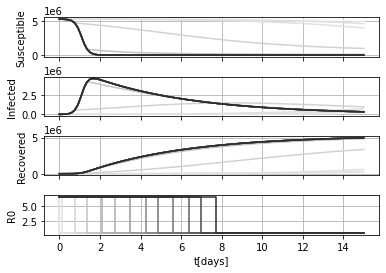

In [10]:
from matplotlib import cm
from matplotlib.ticker import FormatStrFormatter

colormap = cm.get_cmap('Greys', len(x_sols))
colors = colormap(np.linspace(.1, .8, len(x_sols)))

fig2, ax2 = plt.subplots(4)
marker = ''
for i, (u_sol, x_sol, lbd_sol, color) in enumerate(zip(u_sols, x_sols, lbd_sols, colors)):
    if i == (len(x_sols)-1):
        marker = ''
    ax2[0].plot(tgrid, x_sol[:,0], color=color, marker=marker,markersize=2.5)
    ax2[1].plot(tgrid, x_sol[:,1], color=color, marker=marker,markersize=2.5)
    ax2[2].plot(tgrid, x_sol[:,2], color=color, marker=marker,markersize=2.5)
    ax2[3].step(tgrid, u_sol, color=color, marker=marker,markersize=2.5)
_ = [x.grid() for x in ax2]
_ = [x.set_xticklabels([]) for x in ax2[:-1]]

_ = [x.ticklabel_format(axis="y", style="sci", scilimits=(0,0)) for x in ax2[:-1]]
_ = [x.set_ylabel(s) for x, s in zip(ax2, ['Susceptible', 'Infected', 'Recovered', 'R0'])]
ax2[-1].set_xlabel('t[days]')
fig2.subplots_adjust(hspace=.5)

In [11]:
lbd_k

DM([-5.89841e+026, 5.89841e+026, 6.21105])